In [1]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image as Img

from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = Img.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch


num_threads = 24
dset = load_dataset("conceptual_captions")

c:\Users\matti\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\matti\Downloads\datasets\src\datasets\load.py:1478: FutureWarning: The repository for conceptual_captions contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conceptual_captions
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
# Random shuffle dset
# Extract batches
# Remove None values
# Transform images
# Perform training

In [3]:
def fetch_images_batch(dset, batch_size, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    for idx in range(0, len(dset), batch_size):
        batch = dset[idx:idx+batch_size]
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
        yield batch

In [119]:
for batch in fetch_images_batch(dset['train'], batch_size=100, num_threads=24):
    btch = batch
    break

In [120]:
btch_idx = []
for idx, img in enumerate(btch['image']):
    if img is not None:
        btch_idx.append(idx)

In [101]:
len(btch_idx)

73

In [24]:
import torch
from torchvision.transforms import v2

In [70]:
class ImageNormalizer:
    def __call__(self, img):
        return img / 255.0

In [121]:
transforms = v2.Compose([
    v2.PILToTensor(),
    v2.RandomCrop(256, pad_if_needed=True, padding_mode='reflect'),
    v2.Resize(64),
    ImageNormalizer(),
])

In [122]:
for idx in btch_idx:
    btch['image'][idx] = transforms(btch['image'][idx])

c:\Users\matti\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [123]:
lst = [btch['image'][idx] for idx in btch_idx]

In [124]:
stack = torch.stack(lst[:64])

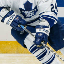

In [131]:
v2.ToPILImage()(stack[6])